In [4]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Audio as audio_playback_widget
import soundfile as sf

import librosa
import librosa.display

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader 
torch.random.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

### Checking audios and folders content

In [5]:
f = './ms-snsd/CleanSpeech_training/clnsp1.wav'
audio_playback_widget(f)

In [6]:
f = './ms-snsd/NoisySpeech_training/noisy1_SNRdb_0.0_clnsp1.wav'
audio_playback_widget(f)

In [7]:
f = './ms-snsd/NoisySpeech_training/noisy1_SNRdb_40.0_clnsp1.wav'
audio_playback_widget(f)

### Checking folders content

In [8]:
path_to_clean = './ms-snsd/CleanSpeech_training/'

os.listdir(path_to_clean)

['clnsp1.wav',
 'clnsp10.wav',
 'clnsp11.wav',
 'clnsp12.wav',
 'clnsp13.wav',
 'clnsp14.wav',
 'clnsp15.wav',
 'clnsp16.wav',
 'clnsp17.wav',
 'clnsp18.wav',
 'clnsp19.wav',
 'clnsp2.wav',
 'clnsp20.wav',
 'clnsp21.wav',
 'clnsp22.wav',
 'clnsp23.wav',
 'clnsp24.wav',
 'clnsp25.wav',
 'clnsp26.wav',
 'clnsp27.wav',
 'clnsp28.wav',
 'clnsp29.wav',
 'clnsp3.wav',
 'clnsp30.wav',
 'clnsp31.wav',
 'clnsp32.wav',
 'clnsp33.wav',
 'clnsp34.wav',
 'clnsp35.wav',
 'clnsp36.wav',
 'clnsp37.wav',
 'clnsp38.wav',
 'clnsp39.wav',
 'clnsp4.wav',
 'clnsp40.wav',
 'clnsp41.wav',
 'clnsp42.wav',
 'clnsp43.wav',
 'clnsp44.wav',
 'clnsp45.wav',
 'clnsp46.wav',
 'clnsp47.wav',
 'clnsp48.wav',
 'clnsp49.wav',
 'clnsp5.wav',
 'clnsp50.wav',
 'clnsp51.wav',
 'clnsp52.wav',
 'clnsp53.wav',
 'clnsp54.wav',
 'clnsp55.wav',
 'clnsp56.wav',
 'clnsp57.wav',
 'clnsp58.wav',
 'clnsp59.wav',
 'clnsp6.wav',
 'clnsp60.wav',
 'clnsp61.wav',
 'clnsp62.wav',
 'clnsp7.wav',
 'clnsp8.wav',
 'clnsp9.wav']

In [9]:
%%capture

path_to_noisy = './ms-snsd/NoisySpeech_training/'

os.listdir(path_to_noisy)

### Audio files have 1 channel, same length in seconds and scaled frequency up to 16 Hz

In [10]:
sample_wav_file = './ms-snsd/CleanSpeech_training/clnsp1.wav'

waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate}')

Shape of the waveform: torch.Size([1, 163520])

Sampling rate of the audio file: 16000


In [11]:
sample_wav_file = './ms-snsd/NoisySpeech_training/noisy1_SNRdb_0.0_clnsp1.wav'

waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate}')

Shape of the waveform: torch.Size([1, 163520])

Sampling rate of the audio file: 16000


### Creating MelSpectrograms for clean and noisy audiofiles using torch.audio

In [32]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    
    fig.colorbar(im, ax=axs)
    plt.show()

In [33]:
n_fft = 1024
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=n_fft,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   norm='slaney',
                                   onesided=True,
                                   n_mels=n_mels,
                                   mel_scale="htk")

In [31]:
sample_wav_file = './ms-snsd/CleanSpeech_training/clnsp1.wav'

waveform, sample_rate = torchaudio.load(sample_wav_file)

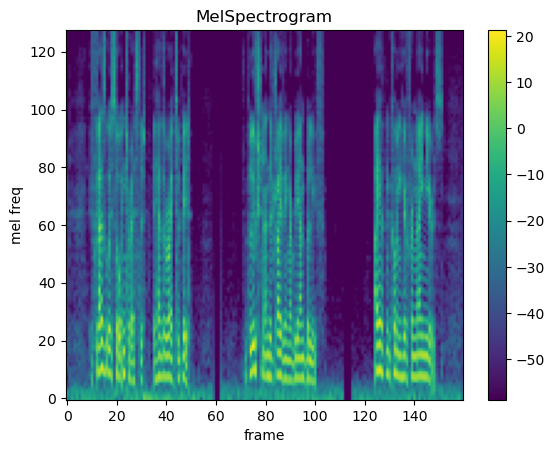

In [35]:
melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')

In [36]:
sample_wav_file = './ms-snsd/NoisySpeech_training/noisy1_SNRdb_0.0_clnsp1.wav'

waveform, sample_rate = torchaudio.load(sample_wav_file)

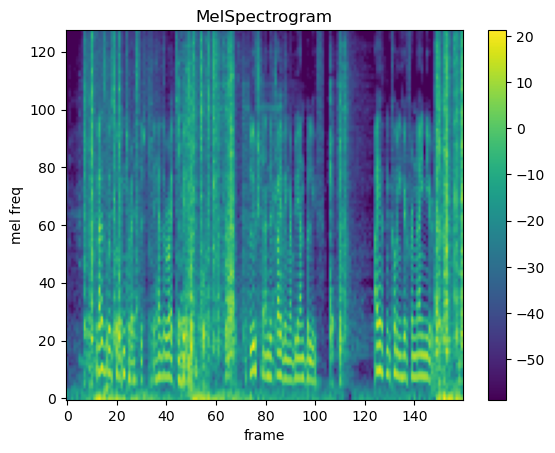

In [37]:
melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')

### Creating MelSpectrograms for clean and noisy audiofiles using librosa

In [20]:
def create_mel_spectrogram_temp(signal, sr):
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(power_to_db, sr=sr, 
                             x_axis='time', y_axis='mel', 
                             cmap='magma', hop_length=hop_length)
    plt.colorbar(label='dB')
    plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))
    plt.ylabel('Frequency', fontdict=dict(size=15))
    plt.show()

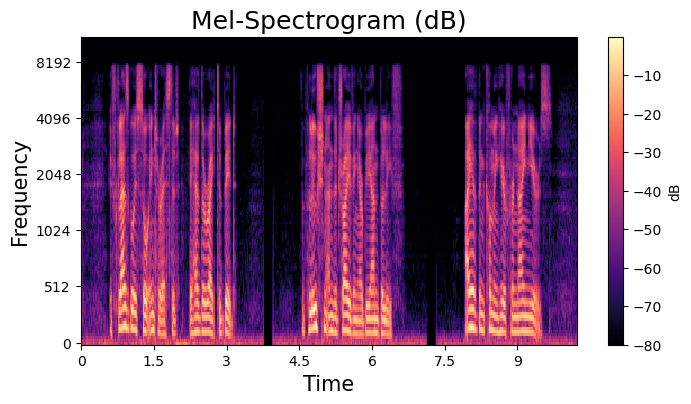

In [21]:
signal, sr = librosa.load('./ms-snsd/CleanSpeech_training/clnsp1.wav')
create_mel_spectrogram_temp(signal, sr)

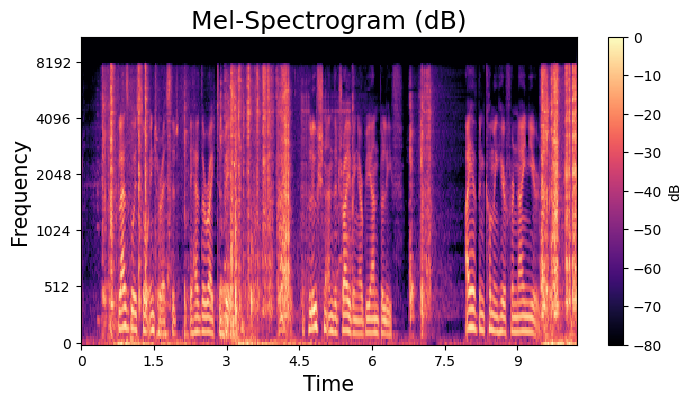

In [22]:
signal, sr = librosa.load('./ms-snsd/NoisySpeech_training/noisy1_SNRdb_0.0_clnsp1.wav')
create_mel_spectrogram_temp(signal, sr)

### Creating datasets for clean and noisy speech
labels determine:
* 1 - clean speech
* 0 - noisy speech

In [23]:
def load_audio_files(data_path):
    
    dataset = []
    for file_path in glob.glob(os.path.join(data_path, '*.wav')):

        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate])
        
    return dataset

In [24]:
clean_speech = load_audio_files('./ms-snsd/CleanSpeech_training/')
noisy_speech = load_audio_files('./ms-snsd/NoisySpeech_training/')

In [25]:
print(f'Length of clean speech dataset: {len(clean_speech)}')
print(f'Length of noisy speech dataset: {len(noisy_speech)}')

Length of clean speech dataset: 62
Length of noisy speech dataset: 310


### Creating DataLoader

In [26]:
trainloader_clean = DataLoader(clean_speech, batch_size=1, shuffle=True)
trainloader_noisy = DataLoader(noisy_speech, batch_size=1, shuffle=True)

### Creating MelSpectrograms and saving them

In [27]:
def audio_to_mel_spec(trainloader, save_dir, label):        
    
    for i, data in enumerate(trainloader):
        waveform = data[0]
        sample_rate = data[1][0]
        label = label        
        
        mel_spec = T.MelSpectrogram()(waveform);
        
        fig = plt.figure()
        plt.imsave(f'./{save_dir}/mel_spec_{i}.png', 
                   mel_spec[0].log2()[0, :, :].numpy(), 
                   cmap='magma')

In [30]:
%%capture
audio_to_mel_spec(trainloader_clean, './ms-snsd/mel_specs/', label=1);
audio_to_mel_spec(trainloader_noisy, './ms-snsd/mel_specs/', label=0);